<a href="https://colab.research.google.com/github/TanmoyGG/Threads_App_Reviews-Sentiment-Classification-with-Multinomial-Naive-Bayes/blob/main/Sentiment%20Classification(Naive%20Bayes).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Threads App Reviews — Sentiment Classification with Multinomial Naïve Bayes





### Setup: Imports & NLTK data


In [ ]:
import os, re, string, math, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,classification_report, confusion_matrix)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import ConfusionMatrixDisplay


nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

print("Libraries ready.")

Libraries ready.


### Load dataset


In [ ]:
DATA_PATH = '/content/threads_reviews.csv'

try:
    df = pd.read_csv(DATA_PATH)
    print("Loaded file:", DATA_PATH)
    print("Shape:", df.shape)
    print("Dataset is perfectly loaded now")
    print("Here is the overview of 10 rows")
    display(df.head(10))
except Exception as e:
    print("Could not read CSV from DATA_PATH:", e)
    print("Please update DATA_PATH to point to the Kaggle CSV (e.g., threads_reviews.csv).")

    df = pd.DataFrame()


Loaded file: /content/threads_reviews.csv
Shape: (32910, 4)
Dataset is perfectly loaded now
Here is the overview of 10 rows


,source,review_description,rating,review_date
0,Google Play,Meh. Not the greatest experience on a Chromebo...,2,2023-07-08 14:18:24
1,Google Play,Pretty good for a first launch!! Its easy to u...,3,2023-07-19 20:52:48
2,Google Play,"For a brand new app, it's very well optimized....",3,2023-07-06 23:03:11
3,Google Play,"Great app with a lot of potential! However, th...",3,2023-07-10 00:53:25
4,Google Play,"The app is good, but it needs a lot of functio...",3,2023-07-06 16:57:43
5,Google Play,"Currently, it's very challenging to use. It's ...",2,2023-07-18 22:30:10
6,Google Play,I still don’t want to see content from people ...,1,2023-07-19 19:35:31
7,Google Play,Could be great if all pages loaded when you cl...,2,2023-07-06 14:35:15
8,Google Play,I'm liking the concept! There is room for impr...,3,2023-07-09 03:27:39
9,Google Play,Not bad! This is its first launch. There is st...,5,2023-07-06 23:41:13


### Dataset INFO

In [ ]:
df.info()
print(df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32910 entries, 0 to 32909
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   source              32910 non-null  object
 1   review_description  32910 non-null  object
 2   rating              32910 non-null  int64 
 3   review_date         32910 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.0+ MB
Index(['source', 'review_description', 'rating', 'review_date'], dtype='object')


### Create labels (positive/negative)


In [ ]:
text_col = 'review_description'
rating_col = 'rating'
data = df[[text_col, rating_col]].copy()

def map_rating_to_sentiment(rating):
    if rating >= 4:
        return 'positive'
    if rating <= 2:
        return 'negative'
    return 'neutral'


data['sentiment'] = data[rating_col].apply(map_rating_to_sentiment)


data = data[data['sentiment'] != 'neutral']


data = data.rename(columns={text_col: 'text'})
data = data[['text', 'sentiment']]


data = data.reset_index(drop=True)

print("Label distribution (after dropping neutrals):")
print(data['sentiment'].value_counts())
display(data.head())

Label distribution (after dropping neutrals):
sentiment
positive    18803
negative    11522
Name: count, dtype: int64


,text,sentiment
0,Meh. Not the greatest experience on a Chromebo...,negative
1,"Currently, it's very challenging to use. It's ...",negative
2,I still don’t want to see content from people ...,negative
3,Could be great if all pages loaded when you cl...,negative
4,Not bad! This is its first launch. There is st...,positive


###   Sentiment Distribution Bar Chart

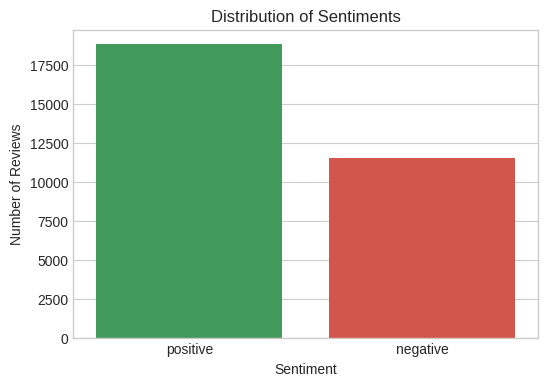

In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')

plt.figure(figsize=(6, 4))
sns.countplot(x='sentiment', data=data, palette=['#34A853', '#EA4335'], order=['positive', 'negative'])
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

### Case folding


In [ ]:
def case_folding(text):
    return text.lower()

data['text_casefold'] = data['text'].astype(str).apply(case_folding)
display(data[['text','text_casefold']].head(5))


,text,text_casefold
0,Meh. Not the greatest experience on a Chromebo...,meh. not the greatest experience on a chromebo...
1,"Currently, it's very challenging to use. It's ...","currently, it's very challenging to use. it's ..."
2,I still don’t want to see content from people ...,i still don’t want to see content from people ...
3,Could be great if all pages loaded when you cl...,could be great if all pages loaded when you cl...
4,Not bad! This is its first launch. There is st...,not bad! this is its first launch. there is st...


### Tokenization


In [ ]:
def tokenize(text):
    return word_tokenize(text)

data['tokens'] = data['text_casefold'].apply(tokenize)
display(data[['text_casefold','tokens']].head(5))

,text_casefold,tokens
0,meh. not the greatest experience on a chromebo...,"[meh, ., not, the, greatest, experience, on, a..."
1,"currently, it's very challenging to use. it's ...","[currently, ,, it, 's, very, challenging, to, ..."
2,i still don’t want to see content from people ...,"[i, still, don, ’, t, want, to, see, content, ..."
3,could be great if all pages loaded when you cl...,"[could, be, great, if, all, pages, loaded, whe..."
4,not bad! this is its first launch. there is st...,"[not, bad, !, this, is, its, first, launch, .,..."


### Punctuation removal


In [ ]:
punct_table = str.maketrans('', '', string.punctuation)

def remove_punct(tokens):
    return [t.translate(punct_table) for t in tokens if t.translate(punct_table).strip() != '']

data['tokens_nopunct'] = data['tokens'].apply(remove_punct)
display(data[['tokens','tokens_nopunct']].head(5))

,tokens,tokens_nopunct
0,"[meh, ., not, the, greatest, experience, on, a...","[meh, not, the, greatest, experience, on, a, c..."
1,"[currently, ,, it, 's, very, challenging, to, ...","[currently, it, s, very, challenging, to, use,..."
2,"[i, still, don, ’, t, want, to, see, content, ...","[i, still, don, ’, t, want, to, see, content, ..."
3,"[could, be, great, if, all, pages, loaded, whe...","[could, be, great, if, all, pages, loaded, whe..."
4,"[not, bad, !, this, is, its, first, launch, .,...","[not, bad, this, is, its, first, launch, there..."


### Stop words removal


In [ ]:
default_stopwords = set(stopwords.words('english'))

exclusions = {"not", "no", "nor", "don't", "isn't", "aren't"}


FINAL_STOPWORDS = default_stopwords - exclusions

def remove_stopwords(tokens):
    return [t for t in tokens if t not in FINAL_STOPWORDS]


data['tokens_nostop'] = data['tokens_nopunct'].apply(remove_stopwords)
display(data[['tokens_nopunct','tokens_nostop']].head(5))

,tokens_nopunct,tokens_nostop
0,"[meh, not, the, greatest, experience, on, a, c...","[meh, not, greatest, experience, chromebook, s..."
1,"[currently, it, s, very, challenging, to, use,...","[currently, challenging, use, dark, mode, want..."
2,"[i, still, don, ’, t, want, to, see, content, ...","[still, ’, want, see, content, people, ’, spec..."
3,"[could, be, great, if, all, pages, loaded, whe...","[could, great, pages, loaded, clicked, sometim..."
4,"[not, bad, this, is, its, first, launch, there...","[not, bad, first, launch, still, room, improve..."


### Stemming


In [ ]:
stemmer = PorterStemmer()

def stem_tokens(tokens):
    return [stemmer.stem(t) for t in tokens]

data['tokens_stem'] = data['tokens_nostop'].apply(stem_tokens)
display(data[['tokens_nostop','tokens_stem']].head(5))


,tokens_nostop,tokens_stem
0,"[meh, not, greatest, experience, chromebook, s...","[meh, not, greatest, experi, chromebook, seem,..."
1,"[currently, challenging, use, dark, mode, want...","[current, challeng, use, dark, mode, want, cha..."
2,"[still, ’, want, see, content, people, ’, spec...","[still, ’, want, see, content, peopl, ’, speci..."
3,"[could, great, pages, loaded, clicked, sometim...","[could, great, page, load, click, sometim, nt,..."
4,"[not, bad, first, launch, still, room, improve...","[not, bad, first, launch, still, room, improv,..."


### Lemmatization


In [ ]:
lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(t) for t in tokens]

data['tokens_lemma'] = data['tokens_nostop'].apply(lemmatize_tokens)
display(data[['tokens_nostop','tokens_lemma']].head(5))


,tokens_nostop,tokens_lemma
0,"[meh, not, greatest, experience, chromebook, s...","[meh, not, greatest, experience, chromebook, s..."
1,"[currently, challenging, use, dark, mode, want...","[currently, challenging, use, dark, mode, want..."
2,"[still, ’, want, see, content, people, ’, spec...","[still, ’, want, see, content, people, ’, spec..."
3,"[could, great, pages, loaded, clicked, sometim...","[could, great, page, loaded, clicked, sometime..."
4,"[not, bad, first, launch, still, room, improve...","[not, bad, first, launch, still, room, improve..."


### Synonym substitution


In [ ]:
def first_synonym(word):
    synsets = wordnet.synsets(word)
    for syn in synsets:
        for lemma in syn.lemmas():
            name = lemma.name().replace('_',' ').lower()
            if name != word:
                return name
    return word

def synonym_substitution(tokens, prob=0.1, seed=42):
    rng = np.random.default_rng(seed)
    out = []
    for t in tokens:
        if rng.random() < prob and t.isalpha() and len(t) > 3:
            out.append(first_synonym(t))
        else:
            out.append(t)
    return out

data['tokens_syn'] = data['tokens_lemma'].apply(lambda toks: synonym_substitution(toks, prob=0.1, seed=42))
display(data[['tokens_lemma','tokens_syn']].head(5))

,tokens_lemma,tokens_syn
0,"[meh, not, greatest, experience, chromebook, s...","[meh, not, greatest, experience, chromebook, s..."
1,"[currently, challenging, use, dark, mode, want...","[currently, challenging, use, dark, manner, wa..."
2,"[still, ’, want, see, content, people, ’, spec...","[still, ’, want, see, message, people, ’, spec..."
3,"[could, great, page, loaded, clicked, sometime...","[could, great, page, loaded, snap, sometimes, ..."
4,"[not, bad, first, launch, still, room, improve...","[not, bad, first, launch, hush, room, improvem..."


### Prepare text for vectorization


In [ ]:
def detok(tokens):
    return " ".join(tokens)


USE_FIELD = 'tokens_lemma'

data['text_final'] = data[USE_FIELD].apply(detok)
display(data[['text','text_final','sentiment']].head(5))


,text,text_final,sentiment
0,Meh. Not the greatest experience on a Chromebo...,meh not greatest experience chromebook seems c...,negative
1,"Currently, it's very challenging to use. It's ...",currently challenging use dark mode want chang...,negative
2,I still don’t want to see content from people ...,still ’ want see content people ’ specifically...,negative
3,Could be great if all pages loaded when you cl...,could great page loaded clicked sometimes nt p...,negative
4,Not bad! This is its first launch. There is st...,not bad first launch still room improvement wo...,positive


### Vector Semantics (TF‑IDF) + Train MultinomialNB


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    data['text_final'], data['sentiment'], test_size=0.2, random_state=42, stratify=data['sentiment']
)


tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.9)
clf = MultinomialNB(alpha=1.0)

pipeline = Pipeline([
    ('tfidf', tfidf),
    ('nb', clf)
])


sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train
)


pipeline.fit(X_train, y_train, nb__sample_weight=sample_weights)

print("Model trained with balanced class weights.")

Model trained with balanced class weights.


### Evaluate the model


Accuracy: 0.8666
Precision: 0.9042
Recall:    0.8780
F1-score:  0.8909

Classification report:
              precision    recall  f1-score   support

    negative     0.8098    0.8481    0.8285      2304
    positive     0.9042    0.8780    0.8909      3761

    accuracy                         0.8666      6065
   macro avg     0.8570    0.8630    0.8597      6065
weighted avg     0.8683    0.8666    0.8672      6065



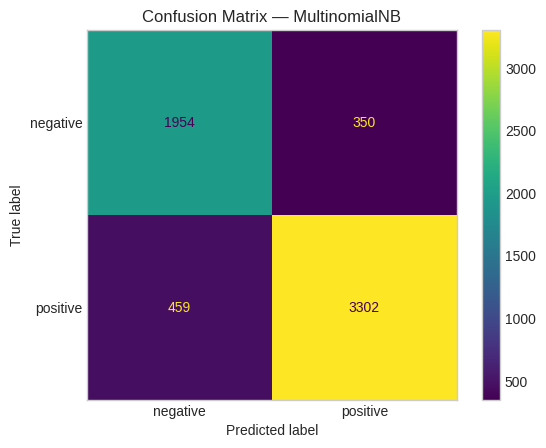

In [ ]:

y_pred = pipeline.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label='positive')

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}\n")

print("Classification report:")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred, labels=['negative','positive'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative','positive'])


fig, ax = plt.subplots()

ax.grid(False)

disp.plot(ax=ax, values_format='d')

plt.title("Confusion Matrix — MultinomialNB")
plt.show()

###  Most Important Words (Feature Importance)

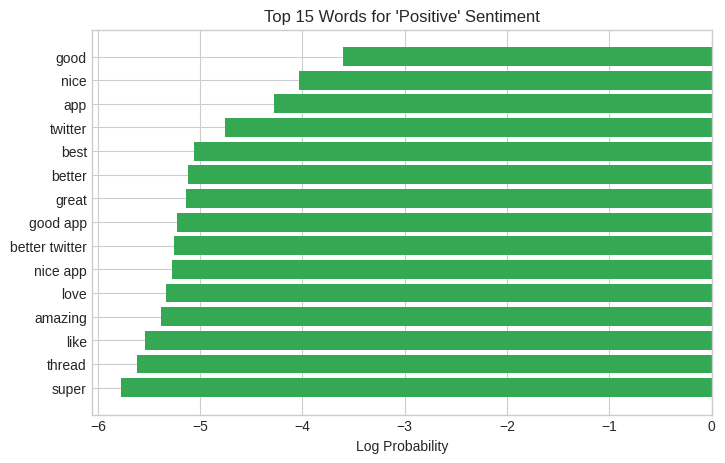

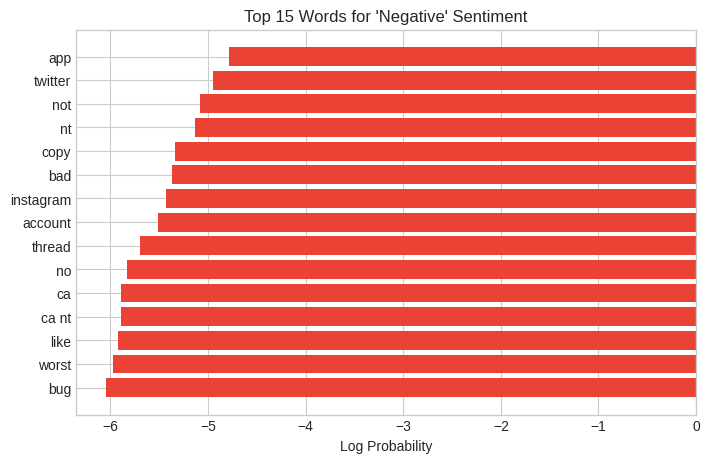

In [ ]:
tfidf_vect = pipeline.named_steps['tfidf']
nb_clf = pipeline.named_steps['nb']


feature_names = tfidf_vect.get_feature_names_out()


log_probs_neg = nb_clf.feature_log_prob_[0]
log_probs_pos = nb_clf.feature_log_prob_[1]


def plot_top_words(log_probs, feature_names, top_n=15, title="Top Words", color='skyblue'):

    top_indices = log_probs.argsort()[-top_n:]
    top_features = feature_names[top_indices]
    top_scores = log_probs[top_indices]

    plt.figure(figsize=(8, 5))
    plt.barh(top_features, top_scores, color=color)
    plt.title(title)
    plt.xlabel("Log Probability")
    plt.show()


plot_top_words(log_probs_pos, feature_names, top_n=15, title="Top 15 Words for 'Positive' Sentiment", color='#34A853')
plot_top_words(log_probs_neg, feature_names, top_n=15, title="Top 15 Words for 'Negative' Sentiment", color='#EA4335')

### Cross-validation


In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='accuracy')
print("CV accuracies:", np.round(scores, 4))
print("Mean CV accuracy:", scores.mean().round(4))


CV accuracies: [0.8735 0.8796 0.8714 0.8772 0.8838]
Mean CV accuracy: 0.8771


### Try predictions


In [ ]:
def predict_sentiment(texts):

    return pipeline.predict(pd.Series(texts))


samples = [
    "I love how smooth the app feels now!",
    "Crashes every time I open it. Worst update ever.",
    "I love my mother",
    "This app is a lifechanger for me",
    "Worst app ever",
    "I Hate Dog",
    "He is a disturbing character",
    "Picchi is a good girl",
    "I Hate Dog",
    "Tanmoy is not a good boy",
    "I don't know nothing"
]


predictions = predict_sentiment(samples)

results_df = pd.DataFrame({
    'Sample Sentence': samples,
    'Predicted Sentiment': predictions
})

display(results_df)

,Sample Sentence,Predicted Sentiment
0,I love how smooth the app feels now!,positive
1,Crashes every time I open it. Worst update ever.,negative
2,I love my mother,positive
3,This app is a lifechanger for me,positive
4,Worst app ever,negative
5,I Hate Dog,negative
6,He is a disturbing character,negative
7,Picchi is a good girl,positive
8,I Hate Dog,negative
9,Tanmoy is not a good boy,negative
